<a href="https://www.kaggle.com/wojciechmokrzycki/analysis-of-lichess-games?scriptVersionId=88885744" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from random import randint
import re

##### Its my first notebook so its basiccly just playing around with data and charts
# TABLE OF CONTENTS
## 1 Getting & Checking Data [-->](#1.-GETTING-&-CHECKING-DATA)
## 2. Overview [-->](#2.-OVERVIEW)
####     - 2.1 Preparing Data
####     - 2.2 Which Color is victorius ?
####     - 2.3 How the game usually ends ?
####     - 2.4 Usually played openings ?
####     - 2.5 How many book moves ?
## 3 GETTING SOME INTERESTING DATA [-->](#3.-GETTING-SOME-INTERESTING-DATA)
####     - 3.1 The Longest and The Shortest game
####     - 3.2 Short or Long castle ?
####     - 3.3 Longest Mate Mesh ?
####     - 3.4 Biggest Rating Diffrence ?
####     - 3.5 Distribution of mates by piece ?
####     - 3.6 How often pons are promoted ?
####     - 3.7 Whats the first move?
####     - 3.8 Exacly the same game?
####     - 3.9 How each field on the chessboard is burdened?
## 4 CONCLUSION [-->](#4.-CONCLUSION)

# 1. GETTING & CHECKING DATA

 - Loading data to the dataframe
 - Checking columns types 
 - checking for missing values 

In [2]:
df = pd.read_csv('/kaggle/input/chess/games.csv')

In [3]:
df.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

#### There is no missing values, so we can proceed
#### Lets check if values in columns are saved in proper type 


In [4]:
df.dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

#### Looks good, but just to be sure lets return random row to check it for sure

In [5]:
df.iloc[randint(0,len(df))]

id                                                         eOpwYIVV
rated                                                          True
created_at                                          1492602321348.0
last_move_at                                        1492602572358.0
turns                                                            24
victory_status                                                 draw
winner                                                         draw
increment_code                                                15+15
white_id                                                   xaabiii9
white_rating                                                   1083
black_id                                                     marigw
black_rating                                                    975
moves             e3 d6 Qh5 g6 Qg4 h5 Qd4 Rh7 Nf3 Nf6 Ng5 Rg7 Nc...
opening_eco                                                     A00
opening_name                                   V

#### Everything looks OK, now we can analyze the dataset

# 2. OVERVIEW

## 2.1 Preparing data
### Lets create the new column which will contain the mean of rating of two players 

In [6]:
df['avg_rating'] = (df['white_rating']+df['black_rating'])/2
df['avg_rating'].describe()['min':'max']

min     816.50
25%    1406.50
50%    1568.75
75%    1771.00
max    2475.50
Name: avg_rating, dtype: float64

### as we can see min-max rating is 816-2475 so we can assign any game to some rating range and create new categorical column containing game level

In [7]:
r = (2500-800)/4
print(f'Lets say we have 4 levels \n')
lev_tab = ['low', 'mid', 'high', 'pro']
for x in range(0,4):
    print(lev_tab[x] + ' - ' + str(int(800+r*x)) + '-' + str(int(800+r*(x+1))))

Lets say we have 4 levels 

low - 800-1225
mid - 1225-1650
high - 1650-2075
pro - 2075-2500


In [8]:
def fun(rat):
    for x in range(0,4):
        if rat >= 800+r*x and rat < 800+r*(x+1):
            return lev_tab[x]

df['level'] = df['avg_rating'].apply(fun)
df['level'].value_counts()

mid     10801
high     6941
low      1431
pro       885
Name: level, dtype: int64

#### Okay now we can analyze diffrent aspects of datafram based on game level 
## For Example, lets get average of turns in game for every level

In [9]:
g = df.groupby(df['level']).mean()['turns'].sort_values().round()
print(g)

level
low     50.0
mid     58.0
high    65.0
pro     70.0
Name: turns, dtype: float64


### as we can see the higher the level the game last longer, lets do some data visualization

In [10]:
fig = px.histogram(g, x=g.index, y=g.values, histfunc='avg', labels={'y':'moves'} ,title='Average game lenght',
                   opacity=0.6, color=g.values, color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.update_layout(bargap=0)
fig.show()

## we can also see scatter chart with avg rating value

In [11]:
fig = px.scatter(df, x='turns', y='avg_rating', color='level')
fig.show()

## 2.2 Which color is victorious ?

In [12]:
df['count'] = 1 
piv = pd.pivot_table(df, index='level',values='count', columns='winner',aggfunc='count')
df.drop(columns='count', axis=1)
piv

winner,black,draw,white
level,,,
high,3201,372,3368
low,635,72,724
mid,4890,429,5482
pro,381,77,427


## Data Visualization

In [13]:
colors = ['black', 'lightgrey', 'white']

fig = make_subplots(rows=1, cols=4, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=piv.columns, values=piv.values[1], name='low'),1,1)
fig.add_trace(go.Pie(labels=piv.columns, values=piv.values[2], name='mid'),1,2)
fig.add_trace(go.Pie(labels=piv.columns, values=piv.values[0], name='high'),1,3)
fig.add_trace(go.Pie(labels=piv.columns, values=piv.values[3], name='pro'),1,4)

fig.update_traces(hole=.4, hoverinfo='label+percent+name', textfont_size=14,
                  marker=dict(colors=colors, line=dict(color='#F2F2F2', width=2)))

fig.update_layout(title_text="Victorious Color",
    annotations=[dict(text='LOW', x=0.085, y=0.5, font_size=16, showarrow=False),
                 dict(text='MID', x=0.37, y=0.5, font_size=16, showarrow=False),
                 dict(text='HIGH', x=0.63, y=0.5, font_size=16, showarrow=False),
                 dict(text='PRO', x=0.91, y=0.5, font_size=16, showarrow=False)])
fig.show()

## 2.3 How the games usually ends ?

In [14]:
s = df['victory_status'].value_counts()
fig = px.pie(s, values=s.values, names=s.index, color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()

In [15]:
t = pd.pivot_table(df, values='count', index='level', columns='victory_status',aggfunc='count')
t

victory_status,draw,mate,outoftime,resign
level,,,,
high,351,1694,630,4266
low,68,573,131,659
mid,411,3936,831,5623
pro,76,122,88,599


In [16]:
fig = px.bar(t, color_discrete_sequence=px.colors.sequential.Agsunset, title = 'Victory Status By The Game Rating')
fig.show()

## 2.4 Usually played Openings

In [17]:
print('Most popular Openings')
df['opening_name'].value_counts().head(5)

Most popular Openings


Van't Kruijs Opening                368
Sicilian Defense                    358
Sicilian Defense: Bowdler Attack    296
Scotch Game                         271
French Defense: Knight Variation    271
Name: opening_name, dtype: int64

In [18]:
print('The most infamous Openings')
df['opening_name'].value_counts().tail(5)

The most infamous Openings


Sicilian Defense: Kupreichik Variation                            1
Modern Defense: Lizard Defense |  Mittenberger Gambit             1
French Defense: Rubinstein Variation |  Kasparov Attack           1
French Defense: Tarrasch Variation |  Open System |  Main Line    1
Sicilian Defense: Najdorf Variation |  Polugaevsky Variation      1
Name: opening_name, dtype: int64

In [19]:
len(df['opening_name'].value_counts())

1477

In [20]:
df['opening_name'].value_counts().head(60)

Van't Kruijs Opening                                                 368
Sicilian Defense                                                     358
Sicilian Defense: Bowdler Attack                                     296
Scotch Game                                                          271
French Defense: Knight Variation                                     271
Scandinavian Defense: Mieses-Kotroc Variation                        259
Queen's Pawn Game: Mason Attack                                      232
Queen's Pawn Game: Chigorin Variation                                229
Scandinavian Defense                                                 223
Horwitz Defense                                                      209
Caro-Kann Defense                                                    199
Philidor Defense #3                                                  198
Philidor Defense #2                                                  193
Indian Game                                        

#### as we can see there is a lot of these openings with diffrent variations, we should probalby shorten by combining diffrent variations of the same opening to e.g. lets say around maybe 50 - 150  openings
### But for now lets take the most popular openings with variations


In [21]:
df['opening_name'].value_counts().describe()

count    1477.000000
mean       13.580230
std        31.963709
min         1.000000
25%         1.000000
50%         4.000000
75%        11.000000
max       368.000000
Name: opening_name, dtype: float64

In [22]:
s = df['opening_name'].value_counts().head(30)          # Lets take the 30 most popular openings with variations
tab = '|'.join('^' + r"{}".format(x)+ '$' for x in s.index)
df_open = df.loc[df['opening_name'].str.contains(tab, regex=True)]
print(f'\nWe analyzing {round(len(df_open)/len(df)*100,2)} % of dataset and')
print(len(df_open['opening_name'].value_counts()))
print('most popular openings with variations')


We analyzing 29.09 % of dataset and
30
most popular openings with variations


In [23]:
t = pd.pivot_table(df_open, values='count', columns='winner', index='opening_name', aggfunc='count').fillna(0)
g = df_open.groupby('opening_name').sum()['count']
tab = [[y/g.values[i] for y in x] for i,x in enumerate(t.values)]

In [24]:
fig = go.Figure(data=go.Heatmap(z=tab, x=t.columns, y=t.index, colorscale='plasma'))
fig.update_layout(title='Winner by the opening with variation in %', yaxis_nticks=50, margin=dict(t=60, r=20, b=10, l=20))
fig.show()

In [25]:
g = df_open.groupby(by='opening_name').mean()['turns']
g = g.sort_values()

In [26]:
fig = px.bar(g.values, x=g.values, y=g.index, color=g.values)
fig.update_layout(title='Game lenght by the opening with variation', yaxis_nticks=50)
fig.show()

## Okay now let's merge the the openings with diffrent variations

In [27]:
df_open = df.copy()
df_open['opening_name'] = df_open['opening_name'].str.split(' ').str[0:2]
df_open['opening_name'] = df_open.opening_name.apply(lambda x: ' '.join([str(i).replace(':','') for i in x]))

print('Now we have: ')
print(len(df_open['opening_name'].value_counts()))
print('Openings\n')
print(df_open['opening_name'].value_counts())

Now we have: 
119
Openings

Sicilian Defense       2632
French Defense         1412
Queen's Pawn           1376
Italian Game            981
King's Pawn             948
                       ... 
Valencia Opening          1
Australian Defense        1
Global Opening            1
Doery Defense             1
Pterodactyl Defense       1
Name: opening_name, Length: 119, dtype: int64


### lets drop the openings with less than 30 games

In [28]:
s = df_open['opening_name'].value_counts()
s = s[s<30]
print(f'Dropping {len(s)} openings')
for x in s.index:
    df_open = df_open[~df_open.opening_name.str.contains(x)]

Dropping 57 openings


In [29]:
t = pd.pivot_table(df_open, values='turns' ,index='opening_name', columns='level', aggfunc='mean')
t

level,high,low,mid,pro
opening_name,,,,
Alekhine Defense,60.659574,62.344828,55.955752,74.333333
Benoni Defense,66.250000,NaN,46.409091,77.000000
Bird Opening,55.274510,70.222222,52.934066,64.166667
Bishop's Opening,64.086420,48.821429,53.023364,NaN
Blackmar-Diemer Gambit,57.428571,71.714286,52.410256,70.000000
...,...,...,...,...
Trompowsky Attack,62.466667,124.000000,67.666667,72.200000
Van Geet,63.800000,31.583333,60.742857,115.000000
Van't Kruijs,57.454545,39.407895,59.794355,NaN


In [30]:
fig = go.Figure(data=go.Heatmap(z=t.values[0:31].round(),x=t.columns, y=t.index[0:31], colorscale="Inferno"))
fig.update_layout(title='Game Lenght by opening and level(part 1)', yaxis_nticks=200, margin=dict(t=80, r=200, b=0, l=200))
fig.show()

In [31]:
fig = go.Figure(data=go.Heatmap(z=t.values[31:62].round(),x=t.columns, y=t.index[31:62], colorscale="Inferno"))
fig.update_layout(title='Game Lenght by opening and level (part 2)', yaxis_nticks=200, margin=dict(t=80, r=200, b=0, l=200))
fig.show()

### as we can see we have some missing values, its because on the some game levels certain openings wasn't played at all
## Let's check who wins on the depending of the opening

In [32]:
table = pd.pivot_table(df_open, values='count' ,index='opening_name', columns='winner', aggfunc='count').fillna(0)
g = df_open.groupby(['opening_name']).sum()['count']
tab = [x/g.values[i] for i,x in enumerate(table.values)]

In [33]:
fig = go.Figure(data=go.Heatmap(z=tab[0:31],x=table.columns, y=table.index[0:31], colorscale="Electric"))
fig.update_layout(title='Winner by opening and level (part 1)', yaxis_nticks=200, margin=dict(t=80, r=200, b=0, l=200))
fig.show()

In [34]:
fig = go.Figure(data=go.Heatmap(z=tab[31:62],x=table.columns, y=table.index[31:62], colorscale="Electric"))
fig.update_layout(title='Winner by opening (part 2)', yaxis_nticks=200, margin=dict(t=80, r=200, b=0, l=200))
fig.show()

### lets consider the game level too

In [35]:
def fun(o):
    if o == 'white':
        return 1 
    elif o == 'draw':
        return 0
    else:
        return -1

df_open['win_points'] = df_open.winner.apply(fun)
table = pd.pivot_table(df_open, values='win_points' ,index=['opening_name'], columns='level', aggfunc='sum')
table

level,high,low,mid,pro
opening_name,,,,
Alekhine Defense,0.0,2.0,19.0,3.0
Benoni Defense,-2.0,NaN,-5.0,2.0
Bird Opening,-15.0,2.0,-7.0,-2.0
Bishop's Opening,18.0,1.0,47.0,NaN
Blackmar-Diemer Gambit,6.0,-3.0,-1.0,-1.0
...,...,...,...,...
Trompowsky Attack,5.0,0.0,2.0,-2.0
Van Geet,-2.0,-2.0,-7.0,0.0
Van't Kruijs,-12.0,-7.0,-81.0,NaN


In [36]:
fig = go.Figure(data=go.Heatmap(z=table.values[0:31],x=table.columns, y=table.index[0:31], colorscale="Hot"))
fig.update_layout(title='Win by opening and level(part 1)', yaxis_nticks=200, margin=dict(t=80, r=200, b=0, l=200))
fig.show()

In [37]:
fig = go.Figure(data=go.Heatmap(z=table.values[31:62],x=table.columns, y=table.index[31:62], colorscale="Hot"))
fig.update_layout(title='Win by opening and level(part 2)', yaxis_nticks=200, margin=dict(t=80, r=200, b=0, l=200))
fig.show()

### as we can see negative values means that black is more likely to win

## 2.5 How many book moves?
### Lets check how many book moves players play in case of game rating

In [38]:
print('The average amount of book moves is:')
print(round(df['opening_ply'].mean()))
print('\n')
df['opening_ply'].value_counts().sort_index()

The average amount of book moves is:
5




1     1097
2     2935
3     3490
4     3308
5     2730
6     2020
7     1344
8     1116
9      687
10     432
11     425
12     142
13     127
14      57
15      43
16      31
17      37
18      12
19      11
20       8
22       1
24       1
28       4
Name: opening_ply, dtype: int64

### Okay lets take only the games which are longer than 20 moves and games of amount of opening moves equal or less than 20

In [39]:
df_open = df.loc[(df['opening_ply'] <= 20) &  (df['turns'] >= 20),['level', 'opening_ply']]
print(f'We will consider {round((len(df_open)*100/len(df)),2)} % of data from our dataset')

We will consider 91.69 % of data from our dataset


### To make this accurate we have to take % of every amount of moves separetly from every game level, because amount of games on diffrent levels is much diffrent

In [40]:
slow = df_open.loc[df_open['level']=='low',['opening_ply']].value_counts()
smid = df_open.loc[df_open['level']=='mid',['opening_ply']].value_counts()
shigh = df_open.loc[df_open['level']=='high',['opening_ply']].value_counts()
spro = df_open.loc[df_open['level']=='pro',['opening_ply']].value_counts()

slow, smid, spro, shigh = slow.sort_index()*100/slow.sum(), smid.sort_index()*100/smid.sum(), spro.sort_index()*100/spro.sum(), shigh.sort_index()*100/shigh.sum()
df_open = pd.DataFrame([spro.values, shigh.values, smid.values, slow.values], columns=[str(x) for x in range(1,21)]).fillna(0)

## Data Visualization

In [41]:
fig = px.imshow(df_open, labels=dict(x="Number of Book Moves", y="Rating", color="%"),
                x=[x for x in range(1,21)], y=['pro','high','mid','low'])
fig.show()

### Okay lets look at the cummulative Heatmap, because anybody who did e.g. 10 book moves also did it less

In [42]:
slow = slow.sort_index(ascending=False).cumsum().sort_index()
smid = smid.sort_index(ascending=False).cumsum().sort_index()
shigh = shigh.sort_index(ascending=False).cumsum().sort_index()
spro = spro.sort_index(ascending=False).cumsum().sort_index()
df_open = pd.DataFrame([spro.values, shigh.values, smid.values, slow.values], columns=[str(x) for x in range(1,21)]).fillna(0)

In [43]:
fig = px.imshow(df_open, labels=dict(x="Number of Book Moves", y="Rating", color="%"),
                x=[x for x in range(1,21)], y=['pro','high','mid','low'])
fig.show()

### Lets take a look at the funnel chart, lets take firt 10 moves and another 10 seperatly to get a better view

In [44]:
y = df_open.columns.values[0:10]
fig = go.Figure()
fig.add_trace(go.Funnel(name='low',y=y, x=df_open.values[3][0:10], textinfo = 'percent total'))
fig.add_trace(go.Funnel(name='mid',y=y, x=df_open.values[2][0:10], textinfo = 'percent total'))
fig.add_trace(go.Funnel(name='high',y=y, x=df_open.values[1][0:10], textinfo = 'percent total'))
fig.add_trace(go.Funnel(name='pro',y=y, x=df_open.values[0][0:10], textinfo = 'percent total'))

fig.show()

In [45]:
y = df_open.columns.values[10:20]
fig = go.Figure()
fig.add_trace(go.Funnel(name='low',y=y, x=df_open.values[3][10:20], textinfo = 'percent total'))
fig.add_trace(go.Funnel(name='mid',y=y, x=df_open.values[2][10:20], textinfo = 'percent total'))
fig.add_trace(go.Funnel(name='high',y=y, x=df_open.values[1][10:20], textinfo = 'percent total'))
fig.add_trace(go.Funnel(name='pro',y=y, x=df_open.values[0][10:20], textinfo = 'percent total'))

fig.show()

# 3. GETTING SOME INTERESTING DATA

## 3.1 Getting The Shortest and The Longest Game 

In [46]:
print(int(df.loc[df['victory_status'] == 'mate'].describe().min()['turns']))
print(df['turns'].max())

4
349


#### The result its absoulutly correct, anyone who play chess knows that 4 is the min amount of moves in the game of chess, it happen when white player loses by mate by black queen on h4 ( Qh4# ) - its called Fool's Mate and it goes like this: g4 e5(or e6) f3(or f4) Qh4#

### Lets check some info about the longest game, because I am really curious about the opening and couple more details of this game

In [47]:
df.iloc[[df['turns'].idxmax()],[4,5,6,7,9,11,14,15]]

,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_name,opening_ply
11554,349,outoftime,white,10+0,2194,2240,Queen's Gambit Declined: Hastings Variation,13


In [48]:
print(df.iloc[df['turns'].idxmax()]['moves'])

d4 d5 c4 c6 Nf3 Nf6 Nc3 e6 Bg5 h6 Bxf6 Qxf6 Qb3 Qd8 e4 dxe4 Nxe4 Nd7 Bd3 Be7 O-O Nf6 Rfd1 O-O Qc2 Qc7 Qe2 b6 Rac1 Bb7 Nxf6+ Bxf6 d5 exd5 cxd5 c5 Qe4 g6 b3 Qd6 Bc4 Rfe8 Qg4 a6 a4 Kg7 Nd2 Bc8 Qf3 Bf5 h3 h5 Bd3 Bxd3 Qxd3 Qe5 Nc4 Qb8 d6 b5 axb5 axb5 Ne3 Bd4 Nc2 Qxd6 Nxd4 cxd4 Qxd4+ Qxd4 Rxd4 Red8 Rxd8 Rxd8 Rc5 Rd1+ Kh2 Rd2 f3 b4 Rc4 Rb2 Rxb4 h4 Rxh4 Rxb3 Kg3 g5 Rc4 Kg6 h4 gxh4+ Rxh4 Rb2 Rc4 f6 Rc5 Rb4 Kh3 Rd4 Kh2 Rb4 Kh1 Rb1+ Kh2 Rb4 Kg1 Rb2 Kf1 Ra2 Rb5 Rc2 Rd5 Ra2 Kg1 Rb2 Kh1 Rb1+ Kh2 Rb4 Kh3 Rc4 Ra5 Rb4 Kg3 Rc4 Kf2 Rc3 Kf1 Rc2 Kg1 Rb2 Kh1 Rc2 Kh2 Rb2 Kh3 Rb4 Kg3 Rc4 Ra8 Rb4 Rc8 Rd4 Rc7 Rb4 Kh2 Rd4 Kh3 Rb4 Kg3 Rd4 Kf2 Rd3 Kf1 Rd2 Kg1 Rb2 Kh1 Rd2 Kh2 Rb2 Kh3 Rb4 Kg3 Rd4 Rc8 Rb4 Rd8 Rc4 Kh3 Rb4 Rg8+ Kf7 Rh8 Kg6 Rd8 Rc4 Rd1 Rb4 Kh2 Rc4 Kh1 Rb4 Kg1 Rb2 Kh2 Rb4 Kh3 Rc4 Re1 Rb4 g3 Rc4 Rf1 Rb4 Rf2 Rc4 Re2 Rb4 Kg2 Rc4 Kf2 Rc3 Rd2 Rb3 Ra2 Rc3 Rb2 Ra3 Rd2 Rc3 Kg2 Rb3 Rd8 Rc3 Ra8 Rb3 Ra7 Rc3 Ra6 Rb3 Ra5 Rc3 Ra4 Rb3 Ra2 Rc3 Ra1 Rb3 Rc1 Rd3 Re1 Rc3 Re8 Rd3 Rg8+ Kf7 Rh8 Kg7 Rh4 Kg6 Rg4+ Kf7 Ra4 Kg6 Kf2

### Its a game on the really high level with no bonus time per move, but unfortunetly the real game ended after 100 moves when on the board left 2 diffrent rooks and 3 pons, players started doing random moves probalby from lack of timet trying to win with the clock, lets then check another one out out  

In [49]:
df['turns'].sort_values(ascending=False).head(10)

13859    349
11554    349
16386    259
4236     255
16645    226
15478    222
16943    222
6776     221
13230    218
13555    216
Name: turns, dtype: int64

In [50]:
df.iloc[16386,[4,5,6,7,9,11,14,15]]

turns                         259
victory_status               draw
winner                       draw
increment_code               15+5
white_rating                 1441
black_rating                 1461
opening_name      Slav Defense #2
opening_ply                     5
Name: 16386, dtype: object

In [51]:
df.iloc[16386]['moves']

'd4 d5 c4 c6 Nc3 Nf6 Bg5 Nbd7 Qc2 Qb6 e3 h6 Bf4 Qa5 Bd3 g5 Bg3 Ng4 h3 Ngf6 a3 Bg7 b4 Qd8 Rb1 dxc4 Bxc4 e6 Nge2 b5 Bd3 Bb7 O-O h5 Bh2 g4 hxg4 hxg4 a4 Nd5 axb5 Qh4 f3 Qxh2+ Kf2 g3+ Nxg3 cxb5 Rh1 Nxe3 Rxh2 Nxc2 Rxh8+ Bxh8 Bxc2 Bxd4+ Kf1 Bxc3 Ne4 Be5 Bd3 Ke7 Bxb5 Rh8 Kf2 Bd4+ Ke2 Rh2 Kd3 Be5 Rg1 Rh8 Ke3 f5 Rd1 f4+ Ke2 Bc8 Nc5 Kf6 Nxd7+ Kg6 Nxe5+ Kf5 Nc6 Rh2 Rg1 Bb7 Nxa7 e5 Bc6 Ba6+ b5 Bxb5+ Bxb5 Rh7 Nc6 Rb7 Bd3+ Ke6 Na5 Rb2+ Kf1 Rd2 Be4 Rd1+ Kf2 Rd2+ Ke1 Rd8 g3 Rg8 Kf2 fxg3+ Rxg3 Rb8 Ke3 Rb5 Nc4 Rb3+ Bd3 Kd5 Nxe5 Kxe5 f4+ Kf6 f5 Ra3 Rf3 Ra1 Ke4 Re1+ Kf4 Rh1 Rg3 Rh4+ Rg4 Rh1 Rg6+ Kf7 f6 Rh4+ Kg5 Rd4 Rg7+ Ke6 f7 Rd5+ Kg6 Rd8 Rg8 Rxd3 f8=Q Rg3+ Kh7 Rh3+ Qh6+ Rxh6+ Kxh6 Kf7 Kh7 Ke7 Rg6 Kf7 Rh6 Ke7 Kg7 Kd7 Kf7 Kd8 Ke6 Kc8 Kd5 Kc7 Kc5 Kd7 Rg6 Ke7 Rc6 Kd7 Kd5 Ke7 Ke5 Kd7 Ra6 Kc7 Ke6 Kb7 Ra1 Kb6 Rb1+ Kc5 Rc1+ Kd4 Rd1+ Ke4 Re1+ Kd4 Kd6 Kc4 Kc6 Kd4 Kd6 Kc4 Re4+ Kd3 Kd5 Kc3 Kc5 Kd3 Re5 Kd2 Kc4 Kc2 Re2+ Kd1 Kd3 Kc1 Kc3 Kd1 Kd3 Kc1 Re1+ Kb2 Kc4 Kc2 Re2+ Kd1 Kd3 Kc1 Rc2+ Kd1 Rb2 Ke1 Ke3 Kf1 Kf3 Ke1 Ke3 

### from 160-259  move white is trying to set a mate with rook and king - and the game ended by draw beacause it was 50 turns without pon movement or any figure capture

In [52]:
df.iloc[4236]['moves'] #  Same situation 

'e4 e6 Nc3 d5 exd5 exd5 d4 Nf6 Bf4 Be7 Nf3 O-O Bd3 h6 O-O Nc6 Re1 Re8 Ne5 Nxd4 Bh7+ Nxh7 Qxd4 c6 Rad1 Bf5 Re2 f6 Nf3 Bf8 Rxe8 Qxe8 Re1 Qf7 Re2 Re8 Rxe8 Qxe8 Qe3 Qxe3 Bxe3 Bxc2 Bxa7 Bb4 Bd4 Bxc3 Bxc3 Bb1 a3 Kf7 Kf1 Ke6 Ke2 Kd6 Ke3 Kc5 Bd4+ Kc4 Kd2 c5 Be3 d4 Bf4 g5 Bd6 b6 Kc1 Bf5 Kd2 Kb3 Kc1 d3 h3 c4 g4 Be4 Nd4+ Ka4 Kd2 b5 Ke3 Bg6 Bc7 Bf7 Kd2 Bd5 Kc3 Bg2 Ne6 Bxh3 Nd4 Bxg4 f3 Bf5 Bd8 h5 Nc6 h4 Be7 h3 Bd6 h2 Bxh2 g4 fxg4 Bxg4 Nd4 f5 Nc6 Nf6 Bf4 Nd7 Nd4 Nc5 Nc6 Ne4+ Kd4 Nf2 Ke3 Kb3 Kxf2 Kxb2 Ke3 Kc2 Kf2 d2 Bxd2 Kxd2 Kf1 c3 Nd4 c2 Nb3+ Kd3 Nc1+ Kc3 Kf2 Kb2 Nd3+ Kxa3 Ke3 Ka2 Kd4 Ka3 Kc5 f4 Kxb5 Ka2 Kc5 f3 Kd4 f2 Nxf2 c1=Q Nxg4 Qb1 Ne5 Qc1 Kd5 Qc2 Ke6 Qc1 Kf6 Qf1+ Ke6 Qg2 Kd6 Qf2 Ke6 Qe3 Kf6 Qf4+ Ke6 Qg5 Kd5 Qd2+ Ke6 Qa5 Kf5 Qd5 Kf4 Qd6 Kf5 Qb8 Ke4 Qh8 Kd5 Qh5 Kd4 Qh4+ Kd5 Qh1+ Ke6 Qg1 Kf5 Qf1+ Ke6 Qa6+ Kf5 Qa5 Ke6 Qc5 Kf5 Kb3 Ke4 Qe7 Kd5 Qg5 Ke6 Kc3 Kd5 Kd2 Kd6 Ke2 Ke6 Qe3 Kd5 Kf1 Ke6 Kg2 Kf6 Kg3 Kf5 Qf4+ Ke6 Kh4 Kd6 Qf3 Ke6 Qg3 Kd5 Qg1 Ke6 Qe1 Kf5 Qc1 Ke6 Qb2 Kf5 Qc1 Ke6 Qd1 Kf5 Qe1 Ke6 Qe2 

In [53]:
df.iloc[16645]['moves'] #  Same situation

'e4 e6 Nf3 d5 exd5 exd5 d4 Nf6 Bg5 Be7 Nc3 Be6 Bb5+ c6 Ba4 Na6 O-O O-O Ne5 h6 Bxf6 Bxf6 f4 Qc7 Ne2 b5 Bb3 Nb4 a3 Na6 Ng3 Nb8 Qe2 Nd7 f5 Nxe5 dxe5 Bxe5 fxe6 Bxg3 exf7+ Rxf7 Rxf7 Bxh2+ Kh1 Qxf7 Rf1 Bf4 g3 Re8 Qf3 Re3 Qxf4 Qh5+ Qh4 Qe2 Qd8+ Kh7 Qf8 Qh5+ Kg1 Re2 Qf5+ Qg6 g4 h5 Qxh5+ Qxh5 gxh5 Kh6 Rf7 a5 a4 b4 Rf5 g6 hxg6 Kxg6 Rf3 Kg5 Rg3+ Kf4 Rg6 Re1+ Kf2 Rb1 Rxc6 Rxb2 Rc5 d4 Rxa5 d3 Rb5 dxc2 Rxb4+ Ke5 Rb5+ Kd4 Bxc2 Rxc2+ Ke1 Ke3 Kd1 Ra2 a5 Kd3 Kc1 Kc3 Kb1 Kc4 Rh5 Ra3 Kb2 Rf3 a6 Kb4 a7 Rf8 Kc2 Ra8 Rh7 Kb5 Kc3 Kb6 Kb4 Rxa7 Rh6+ Kb7 Kb5 Kc8 Kb6 Rg7 Kc6 Kd8 Kd6 Kc8 Kc6 Kd8 Kd6 Kc8 Rh8+ Kb7 Rh6 Kb6 Kd5+ Kb5 Rh5 Kb4 Kc6 Kc4 Rc5+ Kd4 Kb5 Rb7+ Kc6 Rb8 Rd5+ Ke4 Rd7 Rb1 Kd6 Kf5 Ke7 Re1+ Kf7 Ra1 Rd5+ Ke4 Rh5 Ra7+ Kg6 Kf4 Rh4+ Kg3 Rh6 Kg4 Rh8 Ra6+ Kg7 Kg5 Rg8 Kf5 Rf8+ Kg5 Rg8 Kf5 Rf8+ Ke4 Re8+ Kd5 Rd8+ Kc6 Rc8+ Kd7 Rf8 Ra5 Rf7+ Ke6 Kg6 Ra1 Rf6+ Ke5 Rf5+ Ke4 Rg5 Kf4 Rf5+ Ke4 Rg5 Ra6+ Kh5 Kf4 Rg4+ Kf3 Rg6 Ra1 Rf6+ Ke4 Kg6 Rg1+ Kf7 Ke5 Re6+ Kd5 Rg6 Ra1'

In [54]:
df.iloc[15478]['moves'] # Same situation

'd4 d6 e4 e5 dxe5 dxe5 Qxd8+ Kxd8 Nf3 Nc6 Bb5 Bg4 Bxc6 bxc6 Nxe5 Be6 Nxc6+ Kd7 Nd4 Bc5 Nxe6 fxe6 O-O Nf6 e5 Ne4 Nd2 Nxd2 Bxd2 Rhf8 a3 Bd4 Bc3 Bxc3 bxc3 Rab8 Rab1 Ke7 g3 g5 Kg2 h5 Rb3 Rxb3 cxb3 g4 f4 gxf3+ Rxf3 Rd8 h4 Rd5 Re3 c5 Kh3 a5 g4 hxg4+ Kxg4 Rd1 h5 Ra1 a4 Rb1 h6 Kf7 Rf3+ Kg8 b4 axb4 cxb4 Rxb4+ Rf4 c4 a5 Ra4 Kg5 Kh7 a6 Rxa6 Rxc4 Ra7 Rc6 Re7 Kf6 Re8 Rxe6 Rf8+ Ke7 Ra8 Rf6 Ra7+ Ke6 Ra6+ Kf5 Ra5 Rd6 Rb5 Kf6 Kxh6 Kf7+ Kh7 e6 Rf5+ Ke8 Kg7 Kd7 Ra5 Rd4 Kf6 Rf4+ Ke5 Rf7 Ra7+ Ke8 Ra8+ Ke7 Ra7+ Kf8 Ra8+ Kg7 Kxe6 Rf6+ Ke5 Rf1 Ra7+ Kg6 Ra6+ Kg7 Ra7+ Kg6 Ra6+ Kg7 Ke4 Re1+ Kf4 Rf1+ Kg3 Rg1+ Kf2 Rb1 Kf3 Rb3+ Ke4 Rb8 Ke5 Re8+ Kd6 Rd8+ Ke7 Rd1 Ra7 Rh1 Ke6+ Kg6 Ra6 Kg5 Ra5+ Kf4 Rf5+ Ke4 Re5+ Kd3 Rd5+ Kc4 Rg5 Kb4 Kd5 Ra1 Rg4+ Kb5 Kd6 Ra6+ Kd5 Kb6 Rg6+ Kb7 Rg7+ Kb6 Kc4 Ra8 Rg6+ Kb7 Kb5 Rh8 Rg7+ Kc8 Kb6 Rh6+ Ka7 Rh3 Rg8+ Kc7 Rg7+ Kc6 Rg6+ Kc7 Rg7+ Kc6 Rg8 Rh2 Rc8+ Kd7 Rc4 Ra2+ Kb6 Rb2+ Kc5 Ra2 Rd4+ Ke7 Re4+ Kd7 Kb6 Kd8 Re6 Kd7 Rg6 Ke8 Rg7 Kf8 Rd7'

In [55]:
df.iloc[6776]['moves'] # Same situation

'e4 e5 Nf3 Nc6 Bc4 Bc5 O-O d6 c3 Qf6 d3 h6 Be3 Bb6 d4 Bg4 d5 Nce7 Nbd2 Bd7 a4 Ng6 a5 Bxe3 fxe3 Qe7 Qb3 Rb8 a6 b6 Bb5 Nf6 Qc4 Qd8 Ne1 O-O Nd3 Bxb5 Qxb5 Qd7 c4 Qd8 Nb4 Qe8 Nc6 Ra8 Nb4 Ne7 Rf3 Nd7 Nc6 Nb8 Nxe7+ Qxe7 Raf1 f6 b4 Qd7 Rc1 Qc8 Ra1 c6 Qa4 Qc7 b5 c5 Qd1 Nd7 Qe1 Rf7 Rf5 Nf8 Qg3 Nh7 h4 Raf8 Raf1 Kh8 Qg6 Rg8 Nf3 Qe7 Nh2 Nf8 Qg3 g6 R5f2 h5 Nf3 Nh7 Ng5 Rff8 Ne6 Rf7 Ng5 Rff8 Ne6 Rf7 Qh3 Ra8 g4 Rg8 g5 Ra8 Kh2 Rg8 Qf3 Qd7 Qh3 Qe7 Rf3 Qd7 R1f2 Re7 gxf6 Rf7 Ng5 Qxh3+ Kxh3 Nxg5+ hxg5 Kh7 Kh4 Ra8 Rh2 Rh8 Kg3 Kg8 Kh4 Kf8 Rhf2 Ke8 Kg3 Rhh7 Rh2 Rh8 Rh4 Kf8 Rf2 Ke8 Rh1 Rhh7 Kh4 Kf8 Rhf1 Kg8 Rf5 Rh8 R5f2 Kh7 Rg1 Ra8 Rf5 Rh8 Rf2 Kg8 Kg3 Kf8 Kf3 Rfh7 Ke2 Kf7 Rh2 Ra8 Rg3 Rf8 Kf3 Rfh8 Rd2 Re8 Rh3 Rf8 Kg2 Rfh8 Rf3 Rf8 Kh3 Kg8 Rf5 Rhf7 Rf1 Rh7 Ra1 Rhf7 Rb1 Kh7 Rc1 Rd7 Re1 Rff7 Rf1 Kg8 Kh4 Rh7 Kh3 Kf7 Kh4 Rd8 Rdf2 Rc8 Kh3 Rb8 Rg2 Ra8 Kh4 Rah8 Rg3 Rg8 Rgg1 Rf8 Rf3 Re8 Rc1 Rd8 Rc3 Rc8 Ra3 Rc7 Ra4 Rh8 Ra2'

### Here is kind of funny situation cause of pon structure,if u want check here is the link -> https://lichess.org/bbP6WYuH#121

## 3.2 Long and Short Castle popularity

### I just want to know how much often chess players doing short castle and long castle, we have to remember that each player can castle once during the game,

In [56]:
s = df['moves'].explode()
t,tab = ['O-O', 'O-O-O'], []
for x in range(0,len(t)):
    tab.append(len(s.loc[s.str.contains(t[x], regex=True)]))

tab.append(len(df)*2 - tab[0] - tab[1])
tab = [tab[0]/sum(tab), tab[1]/sum(tab), tab[2]/sum(tab)]

## Data visualization

In [57]:
fig = go.Figure(go.Sunburst(labels='% Castle None Short Long'.split(' '),
                            parents=['', '%' ,'%','Castle', 'Castle'],
                            values=[sum(tab),tab[0]+tab[1] ,tab[2], tab[0], tab[1]],
                            branchvalues='total'))

fig.update_layout(margin = dict(t=30, l=30, r=30, b=30))
fig.show()

## 3.3 Longest Mate Mesh
#### This will be kind of tricky, lets look at the moves column of random row to get a better view

In [58]:
df_mate = df.loc[df['victory_status'] == 'mate']
df_mate.iloc[randint(0,len(df_mate))]['moves']

'e4 e5 Nf3 d6 d4 Bg4 d5 Bxf3 Qxf3 f6 Be2 c6 c4 cxd5 cxd5 Qa5+ Bd2 Qb6 O-O Qxb2 Nc3 Qxd2 Rac1 Ne7 Bb5+ Kd8 Na4 Qxa2 Qc3 Nbc6 Rc2 Nxd5 exd5 Qxd5 Bxc6 bxc6 Qxc6 Qxc6 Rxc6 Rc8 Ra6 Rc7 Rb1 Kd7 Nc3 Rxc3 Rxa7+ Ke6 f3 Be7 g4 Rxf3 Kg2 Rf4 h3 h5 gxh5 Rxh5 Rbb7 Rg5+ Kh2 Rf2+ Kh1 Bd8 Ra8 Be7 Re8 e4 Rexe7+ Kf5 Rb5+ Kf4 Rb4 Rd5 Rexe4+ Kf3 Rf4+ Ke3 Rbe4+ Kd3 Rg4 Rc5 Rd4+ Ke3 Rd1 g5 Ra1 d5 Ra3+ Ke2 Ra2+ Kf3 Rb4 Rc1#'

#### We have to use regular regular expressions to get that exact data we need, unfortunetly RegExp dont support nested sets, so we cant use quantifiers to get the lenght of the mate mesh, so we will have to do it manually

#### We have to remember that:
 - check move can be done; by any figure even by the king, by a pon promotion, by a long/short castle
 - defending move; cant castle, can check king, can protomote a pon
 - mate move has the same properties as check the only diffrence is its ends by # instead of +
 
#### In chess notation we distinguish

- pon move e.g a3
- pon captures exd5
- pon promotion eg. e8=Q
- King, Queen, Rook, Bishop, kNight ; K, Q, R, B, N - eg. Qxe4 ,Qd4
- kNight from line 'a' capture e4 field - e.g. Naxe4
- Rook from field h2 captures h8 field - Rh2xh8
- short and long castle; O-O, O-O-O
- mate - #  - e.g. Qh4#
- check - + - e.g. Re1+
 
#### Patterns in RegExp ( lot of ways to do it ) 
  - CHECK - [^\s+]+[+] 
  - DEFE - [^\s-]+
  - MATE - [^\s+]+#$
 #### Let assume that we check maximum 40 lenght of mate mesh, i am truly convinced that nobody achieved such a long matemesh
  

In [59]:
check, defe, mate, gap = '[^\s+]+[+]', '[^\s-]+', '[^\s+]+#$', '\s'
tab = []
for m in range(0,40):
    tab.append(len(df_mate.loc[df_mate['moves'].str.contains((check+gap+defe+gap)*m+mate, regex=True)]))
print(tab)

[6325, 3128, 1568, 837, 475, 250, 148, 91, 54, 31, 18, 13, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### okay, we got lot of zeros lets get rid of them

In [60]:
tab = [i for i in tab if i != 0]
print(len(tab))

14


### Okay we got it !!! 
#### The longest mate mesh including the mate move is:
## 14 

### as you have seen earlier we got 3 games lets check one of them 

In [61]:
df_mate.loc[df_mate['moves'].str.contains((check+gap+defe+gap)*13+mate, regex=True)].index

Int64Index([575, 1377, 19990], dtype='int64')

In [62]:
df.iloc[575]['moves']

'd4 Nf6 Bf4 g6 e3 Bg7 Nf3 O-O Be2 d6 O-O Nh5 Bg5 h6 Bh4 c5 c3 Bf5 dxc5 dxc5 Qxd8 Rxd8 Bxe7 Rd5 Bc4 Rd7 Bxc5 Rc7 b4 Nd7 Nd4 Nxc5 Nxf5 gxf5 bxc5 Rxc5 Be2 Nf6 Bf3 Ne4 Bxe4 fxe4 Nd2 Re8 Rab1 b6 Rb4 Bxc3 Rxe4 Rxe4 Nxe4 Rc4 Rc1 Rxe4 Rxc3 Ra4 Rc2 Kf8 Kf1 Ke7 Ke2 Kd6 Kd2 Kd5 f3 Rc4 Rxc4 Kxc4 e4 Kd4 g3 a5 a4 Kc4 f4 Kb4 e5 Kxa4 f5 Kb3 e6 fxe6 fxe6 a4 e7 a3 e8=Q a2 Qe6+ Kb2 Qe5+ Kb1 Qe4+ Kb2 Qd4+ Kb1 Qxb6+ Ka1 Qf6+ Kb1 Qf5+ Ka1 Qe5+ Kb1 Qe4+ Ka1 Qd4+ Kb1 Qd3+ Ka1 Qc3+ Kb1 Qc2+ Ka1 Qc1#'

### Looks like a legit game, we got pon promotion and mate mesh only by the queen
#### but lets check another game, because I want to know if situation looks simillar or if more figures are involved during the mate mesh

In [63]:
df.iloc[1377]['moves']

'e4 e6 d3 d5 Nd2 c5 Ngf3 Nc6 g3 Qb6 Bg2 Bd7 O-O Rc8 exd5 exd5 Re1+ Be7 b3 Nf6 Bb2 O-O h3 h6 Ne5 Rfe8 Nxd7 Nxd7 Bxd5 Nb4 Bg2 Nf6 Nc4 Qc7 a3 Nc6 Qf3 b5 Qxc6 Qxc6 Bxc6 Rxc6 Ne5 Re6 f4 Bd6 Kf2 Bxe5 Bxe5 Nd5 c4 bxc4 dxc4 Nb6 Bc3 Rxe1 Bxe1 Rxe1 Rxe1 Kh7 Re7 Nc8 Rc7 Nd6 Rxa7 Ne4+ Kf3 Nd2+ Ke3 Nxb3 Rxf7 Na5 Rc7 Nxc4+ Kf3 Nxa3 Rxc5 Nb1 g4 Nd2+ Ke3 Nf1+ Ke2 Ng3+ Kf3 Nf1 Rc2 Kg6 Rf2 Nh2+ Rxh2 Kf6 Ra2 Kg6 h4 Kh7 Ke4 Kg6 Ra7 Kh7 Kf5 Kg8 Kg6 Kf8 g5 hxg5 hxg5 Ke8 f5 Kf8 f6 gxf6 gxf6 Ke8 f7+ Kf8 Ra8+ Ke7 f8=Q+ Ke6 Re8+ Kd5 Qf5+ Kd4 Rd8+ Ke3 Qe6+ Kf4 Rd4+ Kf3 Qf5+ Ke3 Qd3+ Kf2 Rf4+ Kg2 Qf3+ Kg1 Rg4+ Kh2 Qg2#'

### okay here we have pon involved, then rook, then pon gets promoted and checks the king and finally rook and queen mates the king

### ok that went well, lets get back to our tab, fix it and load it to DataFrame, to get the matemesh distribution 

In [64]:
d = {'lenght_of_mate_mesh' : [x for x in range(1,15)], 'broken_data': tab}
matemesh_df = pd.DataFrame(data=d)
matemesh_df = matemesh_df.sort_values(by='lenght_of_mate_mesh', ascending=False)

matemesh_df['how_many_games'] = matemesh_df['broken_data'].diff().fillna(3.0)
matemesh_df = matemesh_df.astype({'how_many_games': int})
matemesh_df = matemesh_df.drop('broken_data', axis=1)
print(matemesh_df)

    lenght_of_mate_mesh  how_many_games
13                   14               3
12                   13               3
11                   12               7
10                   11               5
9                    10              13
8                     9              23
7                     8              37
6                     7              57
5                     6             102
4                     5             225
3                     4             362
2                     3             731
1                     2            1560
0                     1            3197


## Data Visualization

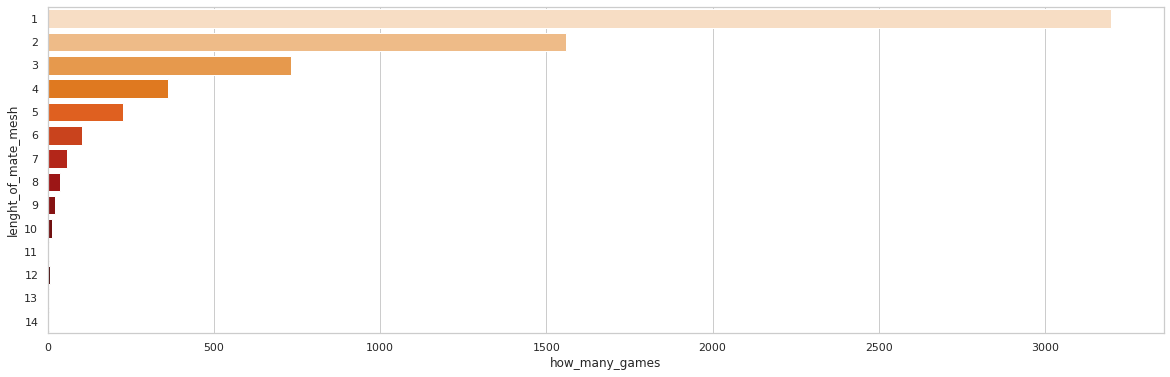

In [65]:
ax = sns.set_theme(style='whitegrid')
plt.figure(figsize=(20,6))
ax = sns.barplot(x='how_many_games', y='lenght_of_mate_mesh', data=matemesh_df, orient='h', palette='gist_heat_r')

#### okay nice thats look kind of like logarithimic distribution, lets turn y axis to logarithmic scale

### Data Visualziation - Logarithmic Distribution

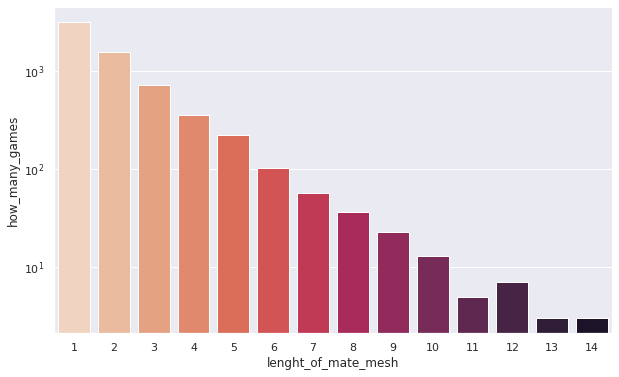

In [66]:
plt.figure(figsize=(10,6))
ax = sns.set_theme(style='darkgrid')
ax = sns.barplot(x='lenght_of_mate_mesh', y='how_many_games', data=matemesh_df, palette='rocket_r')
ax.set_yscale('log')

## 3.4 Biggest Rating Diffrence 
#### Here i want to get the biggest rating diffrence when the player with less rating won

In [67]:
df_mate['rank'] = df_mate['white_rating'] - df_mate['black_rating']
white = df_mate.loc[(df_mate['winner'] == 'white') & (df_mate['rank'] < 0)]['rank'].min()
black = df_mate.loc[(df_mate['winner'] == 'black') & (df_mate['rank'] > 0)]['rank'].max()

if abs(white)>black: 
    print(f'Biggest Rating Diffrence is: {abs(white)}')
else:
    print(f'Biggest Rating Diffrence is: {black}')

Biggest Rating Diffrence is: 830


## 3.5 Distribution of mates by piece
### I am just really currious which pieces doing mate the most often

In [68]:
df_mate = df.loc[df['victory_status'] == 'mate']
pieces = 'queen king rook bishop knight pon pon_promotion short_castle long_castle'.split(' ')
regexp_tab = ['Q.{2,3}', 'K.{2,3}', 'R.{2,5}', 'B.{2,4}', 'N.{2,5}', '[a-x]{0,2}[a-h][1-8]', '[a-x]{0,2}[a-h][1-8]=[NBRQ]', 'O-O', 'O-O-O']
regexp_tab = ['\s'+i+'#$' for i in regexp_tab]
tab = []
for x in range(0,len(regexp_tab)):
    tab.append(len(df_mate.loc[df_mate['moves'].str.contains(regexp_tab[x],regex=True)]))
    
p = pd.Series(tab, index=pieces).sort_values(ascending=False)
print(p)
if p.sum()-len(df_mate) == 0: print('The Data is Accurate')

queen            3974
rook             1623
bishop            273
knight            231
pon               115
pon_promotion     106
king                3
short_castle        0
long_castle         0
dtype: int64
The Data is Accurate


### okay here we can notice that nobody mated with castle which is kind of sad, because thats swag in chess in my subjective opinion. Okay then we can drop the castles

In [69]:
p = p.drop(['short_castle', 'long_castle'])

## Data Visualization

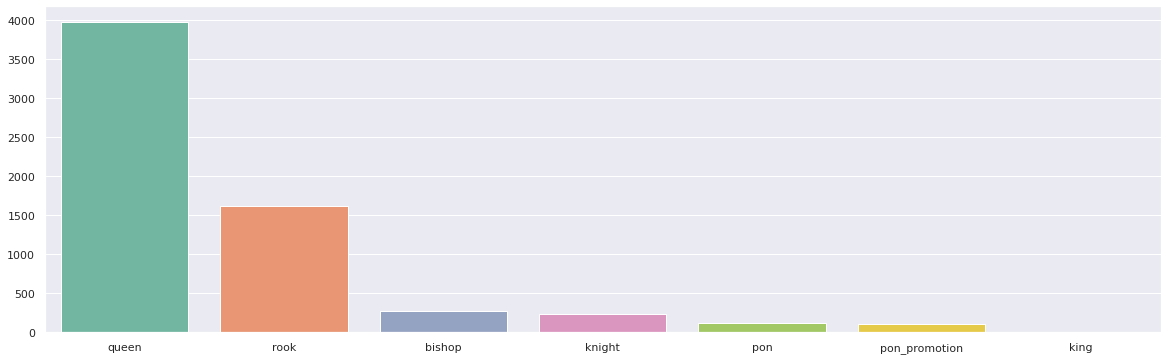

In [70]:
ax = sns.set_theme(style='darkgrid')
plt.figure(figsize=(20,6))
ax = sns.barplot(x=p.index ,y=p.values,palette='Set2')

## 3.6 How often pons are promoted?

In [71]:
num = round(1/(len(df.loc[df['moves'].str.contains('=')])/len(df)))
print(f'We can say that on average in every {num} chess match pon its promoted')

We can say that on average in every 8 chess match pon its promoted


## 3.7 Whats the first move ?


In [72]:
df_move = df.loc[df['moves'] != '']                  # lets take only games with at least one move
s = df_move['moves'].str.split(' ').explode()        # create new series equals to moves column, switch type to list and explode
s = s[~s.index.duplicated(keep='first')]             # drop the duplicate indexes of series 
s_per = s.value_counts()*100/len(df_move)            # First move in %
print(s_per.round(2))

e4     62.81
d4     22.54
Nf3     3.61
c4      3.57
e3      2.07
g3      0.93
b3      0.86
f4      0.83
d3      0.65
Nc3     0.49
b4      0.44
c3      0.28
g4      0.19
h4      0.16
a4      0.14
a3      0.13
f3      0.11
Nh3     0.07
h3      0.07
Na3     0.02
Name: moves, dtype: float64


### We have to preprocess the data because it doesn't look so well, lets combine moves which has less than 5 % 

In [73]:
s1 = s_per.loc[s_per.values>5]
smiss = pd.Series(s_per.loc[s_per.values<=5].sum(),index=['Other move'])
s1 = s1.append(smiss)
s1.round(2)

e4            62.81
d4            22.54
Other move    14.65
dtype: float64

## Data Visualization

In [74]:
fig = px.pie(s1, values=s1.values, names=s1.index, color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_traces(textinfo='percent', textfont_size=20,pull=[0,0,0.3])
fig.show()

### We can also get another 3 most popular moves and add it to the plot 

In [75]:
s2 = s_per.loc[s_per<5].head(3)
print(s2.round(2))

Nf3    3.61
c4     3.57
e3     2.07
Name: moves, dtype: float64


In [76]:
fig = go.Figure(go.Sunburst(labels='First_Move E4 D4 Other Nf3 C4 E3'.split(' '),
                            parents=['','First_Move', 'First_Move', 'First_Move', 'Other','Other', 'Other'],
                            values=[100, s1[0], s1[1], s1[2], s2[0], s2[1], s2[2]],
                            branchvalues='total',marker=dict(colorscale='Agsunset')))

fig.update_layout(margin = dict(t=30, l=30, r=30, b=30),
                  paper_bgcolor='#edd9a3')

fig.show()

## 3.8 Exacly the same game?
#### lets take only the games with more than 10 turns to avoid something like Wayward Queen Attack or Fool's Mate

In [77]:
df_new = df.drop_duplicates()
df_new = df_new.loc[df_new['turns'] >= 10]
print('The most popular game over 10 turns goes like this:')
print(df_new['moves'].value_counts().idxmax())
print('\nand it happens')
print(df_new['moves'].value_counts().max())
print('times')

The most popular game over 10 turns goes like this:
e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5 exd5 Nxd5 Nxf7 Kxf7 Qf3+ Ke8 Bxd5 Nb4 Qf7#

and it happens
3
times


### Its Italian Game: Two Knights Defense, Fried Liver Attack
#### but ended by a quick mate, because of black mistake

## 3.9 How each field on the chessboard is burdened?
### except castles of course, because thats two moves instead of one 

In [78]:
reg_end = '([=QNBR]{0}$|[=QNBR]{2}$|[+#]{1}$)'
s = df['moves'].explode()
s = s.str.extract('([a-h][1-8])'+reg_end)[0]
s = s.value_counts().sort_index()
s = round(s/s.max(),2)
print('The Most popular fields on the chessboard :')
print(s.sort_values(ascending=False).head(5).index)

The Most popular fields on the chessboard :
Index(['f7', 'g7', 'e5', 'g2', 'f3'], dtype='object')


## Data Visualization 

In [79]:
data = np.array([s.values[0:8], s.values[8:16], s.values[16:24], s.values[24:32], s.values[32:40], s.values[40:48], s.values[48:56], s.values[56:64]])
z_text = [[y+x for y in 'abcdefgh'] for x in '12345678']

fig = ff.create_annotated_heatmap(z=data.transpose() ,annotation_text=z_text, colorscale='turbid_r')
fig.update_layout(margin=dict(t=30,r=220,b=10,l=220))
fig.show()

### Okay now lets have a look how it looks like only on the Pro level

In [80]:
s = df.loc[df['level'] == 'pro']['moves'].explode()
s = s.str.extract('([a-h][1-8])'+reg_end)[0]
s = s.value_counts().sort_index()
s = round(s/s.max(),2)
print('The Most popular fields on the chessboard :')
print(s.sort_values(ascending=False).head(5).index)

data = np.array([s.values[0:8], s.values[8:16], s.values[16:24], s.values[24:32], s.values[32:40], s.values[40:48], s.values[48:56], s.values[56:64]])
z_text = [[y+x for y in 'abcdefgh'] for x in '12345678']
fig = ff.create_annotated_heatmap(z=data.transpose() ,annotation_text=z_text, colorscale='turbid_r')
fig.update_layout(margin=dict(t=30,r=220,b=10,l=220))
fig.show()

The Most popular fields on the chessboard :
Index(['g5', 'd5', 'g7', 'f5', 'e4'], dtype='object')


### Okay we can also do it for specific Opening, let's take for example 
## French Defense

In [81]:
s = df.loc[df['opening_name'].str.contains('French Defense')]['moves'].explode()
s = s.str.extract('([a-h][1-8])'+reg_end)[0]
s = s.value_counts().sort_index()
s = round(s/s.max(),2)
print('The Most popular fields on the chessboard :')
print(s.sort_values(ascending=False).head(5).index)

data = np.array([s.values[0:8], s.values[8:16], s.values[16:24], s.values[24:32], s.values[32:40], s.values[40:48], s.values[48:56], s.values[56:64]])
z_text = [[y+x for y in 'abcdefgh'] for x in '12345678']
fig = ff.create_annotated_heatmap(z=data.transpose() ,annotation_text=z_text, colorscale='Bluyl_r')
fig.update_layout(margin=dict(t=40,r=220,b=20,l=220))
fig.show()

The Most popular fields on the chessboard :
Index(['g2', 'f7', 'f3', 'd8', 'd4'], dtype='object')


## Sicilian Defense

In [82]:
s = df.loc[df['opening_name'].str.contains('Sicilian Defense')]['moves'].explode()
s = s.str.extract('([a-h][1-8])'+reg_end)[0]
s = s.value_counts().sort_index()
s = round(s/s.max(),2)
print('The Most popular fields on the chessboard :')
print(s.sort_values(ascending=False).head(5).index)

data = np.array([s.values[0:8], s.values[8:16], s.values[16:24], s.values[24:32], s.values[32:40], s.values[40:48], s.values[48:56], s.values[56:64]])
z_text = [[y+x for y in 'abcdefgh'] for x in '12345678']
fig = ff.create_annotated_heatmap(z=data.transpose() ,annotation_text=z_text, colorscale='matter_r')
fig.update_layout(margin=dict(t=40,r=220,b=10,l=220))
fig.show()

The Most popular fields on the chessboard :
Index(['d4', 'f7', 'd1', 'g2', 'd5'], dtype='object')


## Caro-Kann Defense

In [83]:
s = df.loc[df['opening_name'].str.contains('Caro-Kann Defense')]['moves'].explode()
s = s.str.extract('([a-h][1-8])'+reg_end)[0]
s = s.value_counts().sort_index()
s = round(s/s.max(),2)
print('The Most popular fields on the chessboard :')
print(s.sort_values(ascending=False).head(5).index)

data = np.array([s.values[0:8], s.values[8:16], s.values[16:24], s.values[24:32], s.values[32:40], s.values[40:48], s.values[48:56], s.values[56:64]])
z_text = [[y+x for y in 'abcdefgh'] for x in '12345678']
fig = ff.create_annotated_heatmap(z=data.transpose() ,annotation_text=z_text, colorscale='gray')
fig.update_layout(margin=dict(t=40,r=220,b=10,l=220))
fig.show()

The Most popular fields on the chessboard :
Index(['e1', 'd7', 'e5', 'c7', 'h7'], dtype='object')


## Queen's Pawn Game

In [84]:
s = df.loc[df['opening_name'].str.contains("Queen's Pawn Game")]['moves'].explode()
s = s.str.extract('([a-h][1-8])'+reg_end)[0]
s = s.value_counts().sort_index()
s = round(s/s.max(),2)
print('The Most popular fields on the chessboard :')
print(s.sort_values(ascending=False).head(5).index)

data = np.array([s.values[0:8], s.values[8:16], s.values[16:24], s.values[24:32], s.values[32:40], s.values[40:48], s.values[48:56], s.values[56:64]])
z_text = [[y+x for y in 'abcdefgh'] for x in '12345678']
fig = ff.create_annotated_heatmap(z=data.transpose() ,annotation_text=z_text, colorscale='Purpor_r')
fig.update_layout(margin=dict(t=40,r=220,b=10,l=220))
fig.show()

The Most popular fields on the chessboard :
Index(['d5', 'g2', 'e6', 'e2', 'd2'], dtype='object')


# 4. CONCLUSION

### Game lenght
- The average game lenght is 60 turns
- The higher the rating of the players the game last longer ( linear dependence )
- The game lasts the longest with Robatsh (modern) Defense and English Defense
- The game lasts the shortest with Semi-Slav Defense and Danish Gambit
- The game of chess doesn't usually last more than 100 moves

### Winner
- White color is slightly more likely to win, but when the rating is high draws occurs more often
- Best win rate for white has Nimzowitsh Defense, Rat Defense and Elephant Gambit
- Best win rate for black has Grob Opening and Van't Krujis Opening
- For the mid ranked players best win rate for white has Philidor Defense, although for black Van't Krujis Opening
- For the high ranked players best win rate for white has English Opening and Indian Game for black
- For the pro players white has best win rate with English Opening, black although with Modern Defense

### Opening
- The most popular opening is Opening and Sicilian Defense and Van't Kruijs Opening


### Other Info
- Higher rated players usually resign more often 
- The average amount of book moves in opening plays is : 5
- Short castle is 4.5 more popular than long
- The longest mate mesh in this dataset is 14, frequency is inversly proportional to the lenght of mate mesh and its has logarithmic dependency
- Mate by castle is really rare and usually ain't happen
- We can say that on average in every 8 chess game pon its promoted 
- The most popular field on the chessboard is f7
- The most popular field on the chessboard for Sicilian Defense is d4